## Bots and Gender Profiling
https://pan.webis.de/clef19/pan19-web/author-profiling.html

####  data preprocessing

In [1]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelBinarizer

In [2]:
df_train_full = pd.read_pickle("./pan19_df_clean_train_feateng.pkl")
df_test_full = pd.read_pickle("./pan19_df_clean_test_feateng.pkl")
print(f"train size: {df_train_full.shape}, test size: {df_test_full.shape}")

train size: (412000, 4), test size: (264000, 4)


In [3]:
def feature(df) :
    df['word_count'] = df['tweet'].apply(lambda x : len(x.split()))
    df['char_count'] = df['tweet'].apply(lambda x : len(x.replace(" ","")))
    df['word_density'] = df['word_count'] / (df['char_count'] + 1)
    df['total_length'] = df['tweet'].apply(len)
    df['capitals'] = df['tweet'].apply(lambda tweet: sum(1 for c in tweet if c.isupper()))
    df['caps_vs_length'] = df.apply(lambda row: float(row['capitals'])/float(row['total_length']),axis=1)
    df['num_exclamation_marks'] =df['tweet'].apply(lambda x: x.count('!'))
    df['num_question_marks'] = df['tweet'].apply(lambda x: x.count('?'))
    df['num_punctuation'] = df['tweet'].apply(lambda x: sum(x.count(w) for w in '.,;:'))
    df['num_symbols'] = df['tweet'].apply(lambda x: sum(x.count(w) for w in '*&$%'))
    df['num_unique_words'] = df['tweet'].apply(lambda x: len(set(w for w in x.split())))
    df['words_vs_unique'] = df['num_unique_words'] / df['word_count']
    df["word_unique_percent"] =  df["num_unique_words"]*100/df['word_count']
    df['num_retweet'] = df['clean_tweet'].apply(lambda x: x.count('rt'))
    df['num_url'] = df['clean_tweet'].apply(lambda x: x.count('URL_TOKEN'))
    df['num_number'] = df['clean_tweet'].apply(lambda x: x.count('NUM_TOKEN'))
    return df

In [4]:
## PAZI ovdje uzimam samo subset za lakse igranje
#num_examples = 10_000
#df_train = feature(df_train_full.loc[list(range(5*num_examples)), :])
#df_test = feature(df_test_full.loc[list(range(num_examples)), :])
df_train = feature(df_train_full)
df_test = feature(df_test_full)

df = pd.concat((df_train_full.copy(), df_test_full.copy()))
df_pre = df.copy()
print(f"total size: {df.shape}")

total size: (676000, 20)


In [5]:
df_train.info()
df_train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412000 entries, 0 to 411999
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   author                 412000 non-null  object 
 1   tweet                  412000 non-null  object 
 2   bot                    412000 non-null  object 
 3   clean_tweet            412000 non-null  object 
 4   word_count             412000 non-null  int64  
 5   char_count             412000 non-null  int64  
 6   word_density           412000 non-null  float64
 7   total_length           412000 non-null  int64  
 8   capitals               412000 non-null  int64  
 9   caps_vs_length         412000 non-null  float64
 10  num_exclamation_marks  412000 non-null  int64  
 11  num_question_marks     412000 non-null  int64  
 12  num_punctuation        412000 non-null  int64  
 13  num_symbols            412000 non-null  int64  
 14  num_unique_words       412000 non-nu

author  \
0       47b0c91666f8e47948049eb1fc2202f9   
1       47b0c91666f8e47948049eb1fc2202f9   
2       47b0c91666f8e47948049eb1fc2202f9   
3       47b0c91666f8e47948049eb1fc2202f9   
4       47b0c91666f8e47948049eb1fc2202f9   
...                                  ...   
411995  70ddcdd222a02d2df685e67a38b903d7   
411996  70ddcdd222a02d2df685e67a38b903d7   
411997  70ddcdd222a02d2df685e67a38b903d7   
411998  70ddcdd222a02d2df685e67a38b903d7   
411999  70ddcdd222a02d2df685e67a38b903d7   

                                                    tweet  bot  \
0       Town &amp; Country Magazine Uninvited Monica L...  bot   
1       Lead Business Systems Analyst – Automated Test...  bot   
2       Senior Software Engineer, Business Process Eng...  bot   
3       Technical Support Engineer: Technical Support ...  bot   
4       Mueller questioned Novartis payment to Trump l...  bot   
...                                                   ...  ...   
411995  A little more persistence, a little more effor...  bot   
411996  Perseverance is a great element of success. If...  bot   
411997  Profit is a by-product of work; happiness is i...  bot   
411998  Quality questions create a quality life. Succe...  bot   
411999  He who has a strong enough why can bear almost...  bot   

                                              clean_tweet  word_count  \
0       town country magazine uninvited monica lewinsk...          40   
1       lead business system analyst automated testing...          35   
2       senior software engineer business process engi...          33   
3       technical support engineer technical support e...          35   
4       mueller questioned novartis payment trump lawy...          37   
...                                                   ...         ...   
411995  little persistence little effort seemed hopele...          20   
411996  perseverance great element success knock long ...          26   
411997  profit product work happiness chief product he...          13   
411998  quality question create quality life successfu...          21   
411999   ha strong enough bear almost friedrich nietzsche          14   

        char_count  word_density  total_length  capitals  caps_vs_length  \
0              269      0.148148           308        41        0.133117   
1              268      0.130112           302        37        0.122517   
2              263      0.125000           295        25        0.084746   
3              269      0.129630           303        35        0.115512   
4              264      0.139623           300        33        0.110000   
...            ...           ...           ...       ...             ...   
411995         108      0.183486           127         3        0.023622   
411996         116      0.222222           141         3        0.021277   
411997          63      0.203125            75         3        0.040000   
411998         116      0.179487           136         4        0.029412   
411999          63      0.218750            76         3        0.039474   

        num_exclamation_marks  num_question_marks  num_punctuation  \
0                           0                   0                8   
1                           0                   0               12   
2                           0                   0                9   
3                           0                   0                9   
4                           0                   0                6   
...                       ...                 ...              ...   
411995                      0                   0                3   
411996                      0                   0                3   
411997                      0                   0                2   
411998                      0                   0                4   
411999                      0                   0                1   

        num_symbols  num_unique_words  words_vs_unique  word_unique_percent  \
0 

In [6]:
import plotly.graph_objects as go

fig = go.Figure(
    data=[
        go.Scatterpolar(
            r=[df_train.loc[df_train["bot"] == "bot"]['num_url'].mean() * 100,
               df_train.loc[df_train["bot"] == "bot"]['num_number'].mean() * 100,
               df_train.loc[df_train["bot"] == "bot"]['num_retweet'].mean() * 100],
            theta=['urls', "nums", "Number of retweets"],
            fill='toself',
            line=dict(color='red'),
            name="bot stats means", subplot="polar3"),

        go.Scatterpolar(
            r=[df_train.loc[df_train["bot"] == "human"]['num_url'].mean() * 100,
               df_train.loc[df_train["bot"] == "human"]['num_number'].mean() * 100,
               df_train.loc[df_train["bot"] == "human"]['num_retweet'].mean() * 100],
            theta=['urls', "nums", "Number of retweets"],
            fill='toself',
            line=dict(color='blue'),
            name="human stats means", subplot="polar3"),

        go.Scatterpolar(
            r=[df_train.loc[df_train["bot"] == "bot"]['total_length'].mean(),
                df_train.loc[df_train["bot"] == "bot"]['char_count'].mean(),
                df_train.loc[df_train["bot"] == "bot"]['word_count'].mean()],
            theta=['Total_Lenght', 'Charcount', "word count"],
            fill='toself',
            line=dict(color='brown'),
            name="bot stats means", subplot="polar3"),

        go.Scatterpolar(
            r=[df_train.loc[df_train["bot"] == "human"]['total_length'].mean(),
                df_train.loc[df_train["bot"] == "human"]['char_count'].mean(),
                df_train.loc[df_train["bot"] == "human"]['word_count'].mean()],
            theta=['Total_Lenght', 'Charcount', "word count"],
            fill='toself',
            line=dict(color='magenta'),
            name="human stats means", subplot="polar3")
    ],
    layout=go.Layout(
        polar3=dict(
            domain=dict(
                x=[1, 1],
                y=[1, 1]
            ),
            radialaxis=dict(visible=True,)),
        polar2=dict(
            domain=dict(
                x=[0, 0.3],
                y=[0, 0.45]
            ),
            radialaxis=dict(visible=True,)),

        polar=dict(
            domain=dict(
                x=[0.33, 0.6525],
                y=[0, 0.45]
            ),
            radialaxis=dict(visible=True,)),

        polar4=dict(
            domain=dict(
                x=[0.33, 0.6525],
                y=[0.55, 1]
            ),
            radialaxis=dict(visible=True,)),

        polar5=dict(
            domain=dict(
                x=[0.6775, 1],
                y=[0, 0.45]
            ),
            radialaxis=dict(visible=True,)),
        polar6=dict(
            domain=dict(
                x=[0.6775, 1],
                y=[0.55, 1]
            ),
            radialaxis=dict(visible=True,))
    )
)

fig.show()

In [7]:
def draw_word_features(df_train):
    plot = go.Figure(
    data=[
        go.Scatterpolar(
            r=[df_train.loc[df_train["bot"] == "bot"]['word_count'].mean(),
               df_train.loc[df_train["bot"] == "bot"]['char_count'].mean(),
               df_train.loc[df_train["bot"] == "bot"]['word_density'].mean(),
               df_train.loc[df_train["bot"] == "bot"]['total_length'].mean(),
               df_train.loc[df_train["bot"] == "bot"]['capitals'].mean(),
               df_train.loc[df_train["bot"] == "bot"]['caps_vs_length'].mean()],
            theta=['mean word count', "mean char count", "mean word denisty",
                   "mean tweet length", "mean capital letter count", "mean capital vs length"],
            fill='toself',
            line=dict(color='red'),
            name="bot means", subplot="polar6"),

        go.Scatterpolar(
            r=[df_train.loc[df_train["bot"] == "human"]['word_count'].mean(),
               df_train.loc[df_train["bot"] == "human"]['char_count'].mean(),
               df_train.loc[df_train["bot"] == "human"]['word_density'].mean(),
               df_train.loc[df_train["bot"] == "human"]['total_length'].mean(),
               df_train.loc[df_train["bot"] == "human"]['capitals'].mean(),
               df_train.loc[df_train["bot"] == "human"]['caps_vs_length'].mean()],
            theta=['mean word count', "mean char count", "mean word denisty",
                   "mean tweet length", "mean capital letter count", "mean capital vs length"],
            fill='toself',
            line=dict(color='blue'),
            name="human means", subplot="polar6"),
    ],
    layout=go.Layout(
        polar=dict(
            domain=dict(
                x=[0, 1],
                y=[0, 1]
            ),
            radialaxis=dict(visible=True,)),
        polar2=dict(
            domain=dict(
                x=[0, 1],
                y=[0, 1]
            ),
            radialaxis=dict(visible=True,)),

        polar3=dict(
            domain=dict(
                x=[0, 1],
                y=[0, 1]
            ),
            radialaxis=dict(visible=True,)),
        
        polar4=dict(
            domain=dict(
                x=[0, 1],
                y=[0, 1]
            ),
            radialaxis=dict(visible=True,)),
        
        polar5=dict(
            domain=dict(
                x=[0, 1],
                y=[0, 1]
            ),
            radialaxis=dict(visible=True,)),
        
        polar6=dict(
            domain=dict(
                x=[0, 1],
                y=[0, 1]
            ),
            radialaxis=dict(visible=True,)),
        )
    )
    return plot

fig = draw_word_features(df)
fig.show()

In [8]:
def draw_url_rt_num(df_train):
    plot = go.Figure(
    data=[
        go.Scatterpolar(
            r=[df_train.loc[df_train["bot"] == "bot"]['num_url'].mean(),
               df_train.loc[df_train["bot"] == "bot"]['num_number'].mean(),
               df_train.loc[df_train["bot"] == "bot"]['num_retweet'].mean()],
            theta=['mean URL count', "mean number count", "mean retweet count"],
            fill='toself',
            line=dict(color='red'),
            name="bot means", subplot="polar3"),

        go.Scatterpolar(
            r=[df_train.loc[df_train["bot"] == "human"]['num_url'].mean(),
               df_train.loc[df_train["bot"] == "human"]['num_number'].mean(),
               df_train.loc[df_train["bot"] == "human"]['num_retweet'].mean()],
            theta=['mean URL count', "mean number count", "mean retweet count"],
            fill='toself',
            line=dict(color='blue'),
            name="human means", subplot="polar3"),
    ],
    layout=go.Layout(
        polar=dict(
            domain=dict(
                x=[0, 1],
                y=[0, 1]
            ),
            radialaxis=dict(visible=True,)),
        polar2=dict(
            domain=dict(
                x=[0, 1],
                y=[0, 1]
            ),
            radialaxis=dict(visible=True,)),

        polar3=dict(
            domain=dict(
                x=[0, 1],
                y=[0, 1]
            ),
            radialaxis=dict(visible=True,)),
        )
    )
    return plot

fig = draw_url_rt_num(df)
fig.show()

In [9]:
def draw_uniques(df_train):
    plot = go.Figure(
    data=[
        go.Scatterpolar(
            r=[df_train.loc[df_train["bot"] == "bot"]['num_unique_words'].mean(),
               df_train.loc[df_train["bot"] == "bot"]['words_vs_unique'].mean(),
               df_train.loc[df_train["bot"] == "bot"]['word_unique_percent'].mean()],
            theta=['mean unique words', "mean words vs unique", "mean words unique percent"],
            fill='toself',
            line=dict(color='red'),
            name="bot values", subplot="polar3"),

        go.Scatterpolar(
            r=[df_train.loc[df_train["bot"] == "human"]['num_unique_words'].mean(),
               df_train.loc[df_train["bot"] == "human"]['words_vs_unique'].mean(),
               df_train.loc[df_train["bot"] == "human"]['word_unique_percent'].mean()],
            theta=['mean unique words', "mean words vs unique", "mean words unique percent"],
            fill='toself',
            line=dict(color='blue'),
            name="human values", subplot="polar3"),
    ],
    layout=go.Layout(
        polar=dict(
            domain=dict(
                x=[0, 1],
                y=[0, 1]
            ),
            radialaxis=dict(visible=True,)),
        polar2=dict(
            domain=dict(
                x=[0, 1],
                y=[0, 1]
            ),
            radialaxis=dict(visible=True,)),

        polar3=dict(
            domain=dict(
                x=[0, 1],
                y=[0, 1]
            ),
            radialaxis=dict(visible=True,)),
        )
    )
    return plot

fig = draw_uniques(df)
fig.show()

In [10]:
def draw_punctuation(df_train):
    freq_plot = go.Figure(
    data=[
        go.Scatterpolar(
            r=[df_train.loc[df_train["bot"] == "bot"]['num_exclamation_marks'].mean(),
               df_train.loc[df_train["bot"] == "bot"]['num_question_marks'].mean(),
               df_train.loc[df_train["bot"] == "bot"]['num_punctuation'].mean(),
               df_train.loc[df_train["bot"] == "bot"]['num_symbols'].mean()],
            theta=['mean exclamation marks', "mean question marks", "mean punctuation", "mean symbols"],
            fill='toself',
            line=dict(color='red'),
            name="bot values", subplot="polar4"),

        go.Scatterpolar(
            r=[df_train.loc[df_train["bot"] == "human"]['num_exclamation_marks'].mean(),
               df_train.loc[df_train["bot"] == "human"]['num_question_marks'].mean(),
               df_train.loc[df_train["bot"] == "human"]['num_punctuation'].mean(),
               df_train.loc[df_train["bot"] == "human"]['num_symbols'].mean()],
            theta=['mean exclamation marks', "mean question marks", "mean punctuation", "mean symbols"],
            fill='toself',
            line=dict(color='blue'),
            name="human values", subplot="polar4"),
    ],
    layout=go.Layout(
        polar=dict(
            domain=dict(
                x=[0, 1],
                y=[0, 1]
            ),
            radialaxis=dict(visible=True,)),
        polar2=dict(
            domain=dict(
                x=[0, 1],
                y=[0, 1]
            ),
            radialaxis=dict(visible=True,)),

        polar3=dict(
            domain=dict(
                x=[0, 1],
                y=[0, 1]
            ),
            radialaxis=dict(visible=True,)),
        polar4=dict(
            domain=dict(
                x=[0, 1],
                y=[0, 1]
            ),
            radialaxis=dict(visible=True,)),
        )
    )
    return freq_plot
fig = draw_punctuation(df)
fig.show()

In [11]:
word_features = ["word_count", "char_count", "word_density", "total_length", "capitals", "caps_vs_length"]
punctuation_features = ["num_exclamation_marks", "num_question_marks", "num_punctuation", "num_symbols"]
uniques_features = ["num_unique_words", "words_vs_unique", "word_unique_percent"]
means_features = ["num_retweet", "num_url", "num_number"]

all_new_features = word_features + punctuation_features + uniques_features + means_features
print(len(all_new_features))

16


In [12]:
for feat in all_new_features:
    bot_mean = df.loc[df["bot"] == "bot"][feat].mean()
    bot_std = df.loc[df["bot"] == "bot"][feat].std()
    print(f"{feat}[bot] mean: {bot_mean} | stddev: {bot_std}")
        
    human_mean = df.loc[df["bot"] == "human"][feat].mean()
    human_std = df.loc[df["bot"] == "human"][feat].std()
    print(f"{feat}[human] mean: {human_mean} | stddev: {human_std}")
    
    print(f"mean absolute difference: {abs(bot_mean - human_mean)} | stddev absolute difference: {abs(bot_std - human_std)}")
    print()

word_count[bot] mean: 17.092402366863904 | stddev: 11.161447100720757
word_count[human] mean: 15.67326923076923 | stddev: 9.157090300989807
mean absolute difference: 1.4191331360946737 | stddev absolute difference: 2.0043567997309495

char_count[bot] mean: 106.04140532544379 | stddev: 70.91087747333623
char_count[human] mean: 89.32908875739645 | stddev: 44.473702445375984
mean absolute difference: 16.712316568047342 | stddev absolute difference: 26.437175027960244

word_density[bot] mean: 0.1631583227101447 | stddev: 0.050439161635511834
word_density[human] mean: 0.16923527970625796 | stddev: 0.04649282976566136
mean absolute difference: 0.00607695699611327 | stddev absolute difference: 0.003946331869850474

total_length[bot] mean: 122.04418047337278 | stddev: 81.311742182314
total_length[human] mean: 103.97819822485206 | stddev: 52.90192401944772
mean absolute difference: 18.06598224852071 | stddev absolute difference: 28.409818162866287

capitals[bot] mean: 11.965964497041421 | stdde

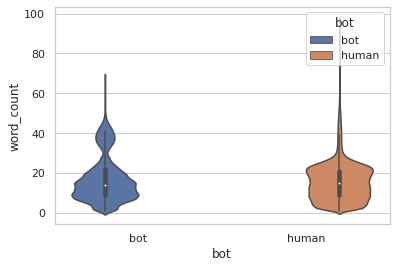

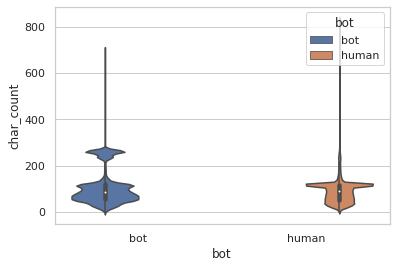

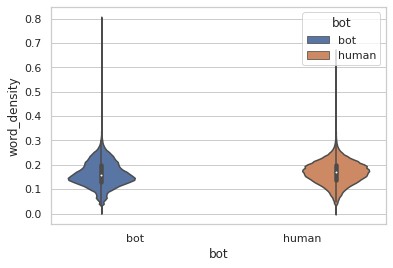

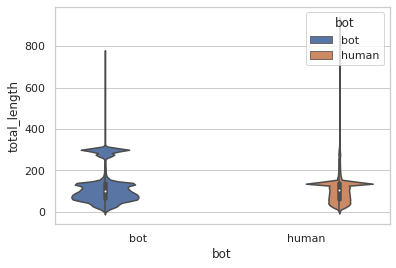

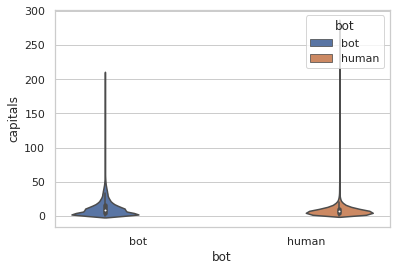

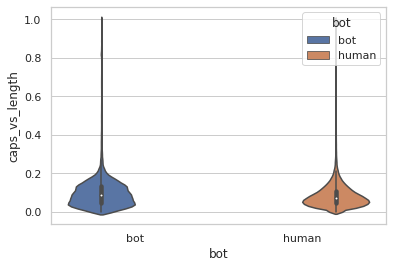

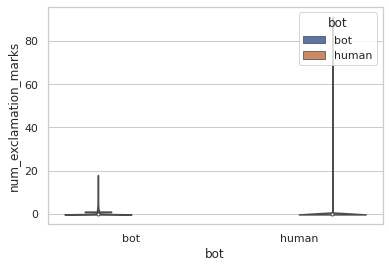

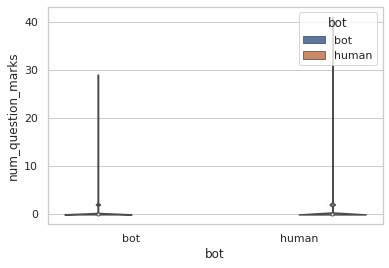

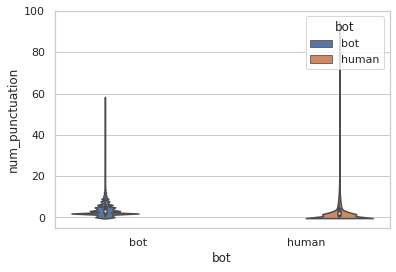

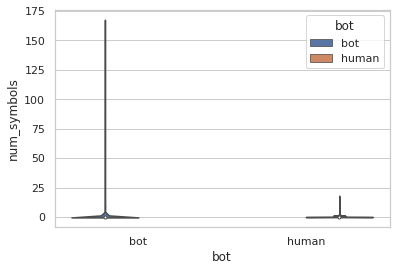

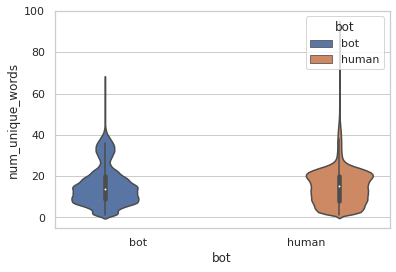

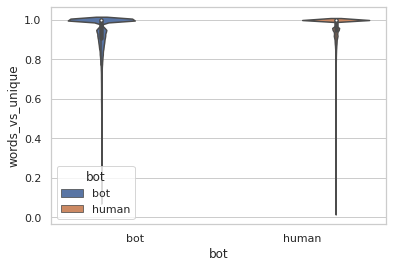

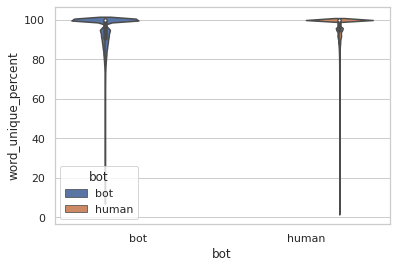

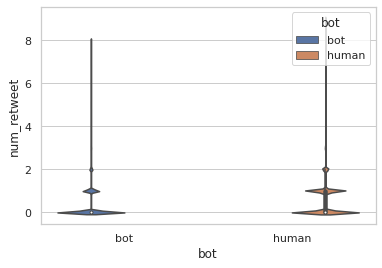

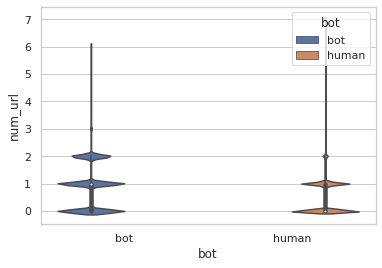

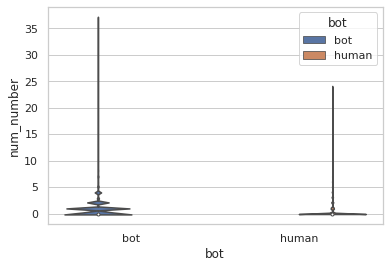

In [13]:
sns.set(style="whitegrid")

def plot_violins_all(dataframe):
    for feature in all_new_features:
        ax = sns.violinplot(x="bot",
                            y=feature,
                            hue="bot",
                            data=dataframe)
        plt.show()

plot_violins_all(df)

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [15]:
ct_full = ColumnTransformer([
    ("all_features", StandardScaler(), all_new_features),
])
df[all_new_features] = ct_full.fit_transform(df)

In [16]:
ct_words = ColumnTransformer([
    ("word_cnt", StandardScaler(), all_new_features),
])

df_train[all_new_features] = ct_words.fit_transform(df_train)
#print(f"train_transformed:\n{df_train}")

df_test[all_new_features] = ct_words.transform(df_test)
#print(f"\n\ntest_transformed:\n{df_test_transformed}")
#df_test
df_train

author  \
0       47b0c91666f8e47948049eb1fc2202f9   
1       47b0c91666f8e47948049eb1fc2202f9   
2       47b0c91666f8e47948049eb1fc2202f9   
3       47b0c91666f8e47948049eb1fc2202f9   
4       47b0c91666f8e47948049eb1fc2202f9   
...                                  ...   
411995  70ddcdd222a02d2df685e67a38b903d7   
411996  70ddcdd222a02d2df685e67a38b903d7   
411997  70ddcdd222a02d2df685e67a38b903d7   
411998  70ddcdd222a02d2df685e67a38b903d7   
411999  70ddcdd222a02d2df685e67a38b903d7   

                                                    tweet  bot  \
0       Town &amp; Country Magazine Uninvited Monica L...  bot   
1       Lead Business Systems Analyst – Automated Test...  bot   
2       Senior Software Engineer, Business Process Eng...  bot   
3       Technical Support Engineer: Technical Support ...  bot   
4       Mueller questioned Novartis payment to Trump l...  bot   
...                                                   ...  ...   
411995  A little more persistence, a little more effor...  bot   
411996  Perseverance is a great element of success. If...  bot   
411997  Profit is a by-product of work; happiness is i...  bot   
411998  Quality questions create a quality life. Succe...  bot   
411999  He who has a strong enough why can bear almost...  bot   

                                              clean_tweet  word_count  \
0       town country magazine uninvited monica lewinsk...    2.314154   
1       lead business system analyst automated testing...    1.824393   
2       senior software engineer business process engi...    1.628488   
3       technical support engineer technical support e...    1.824393   
4       mueller questioned novartis payment trump lawy...    2.020297   
...                                                   ...         ...   
411995  little persistence little effort seemed hopele...    0.355111   
411996  perseverance great element success knock long ...    0.942823   
411997  profit product work happiness chief product he...   -0.330555   
411998  quality question create quality life successfu...    0.453063   
411999   ha strong enough bear almost friedrich nietzsche   -0.232602   

        char_count  word_density  total_length  capitals  caps_vs_length  \
0         2.866896     -0.391454      2.820237  3.146854        0.614797   
1         2.850209     -0.760248      2.733655  2.742487        0.462912   
2         2.766769     -0.864762      2.632643  1.529385       -0.078280   
3         2.866896     -0.770101      2.748086  2.540303        0.362542   
4         2.783457     -0.565775      2.704795  2.338120        0.283571   
...            ...           ...           ...       ...             ...   
411995    0.180144      0.331101      0.208352 -0.694636       -0.954081   
411996    0.313647      1.123132      0.410376 -0.694636       -0.987688   
411997   -0.570812      0.732653     -0.542024 -0.694636       -0.719412   
411998    0.313647      0.249332      0.338225 -0.593544       -0.871124   
411999   -0.570812      1.052136     -0.527594 -0.694636       -0.726954   

        num_exclamation_marks  num_question_marks  num_punctuation  \
0                    -0.29383           -0.248441         1.789318   
1                    -0.29383           -0.248441         3.270997   
2                    -0.29383           -0.248441         2.159738   
3                    -0.29383           -0.248441         2.159738   
4                    -0.29383           -0.248441         1.048479   
...                       ...                 ...              ...   
411995               -0.29383           -0.248441        -0.062781   
411996               -0.29383           -0.248441        -0.062781   
411997               -0.29383           -0.248441        -0.433201   
411998               -0.29383           -0.248441         0.307639   
411999               -0.29383           -0.248441        -0.803620   

        num_symbols  num_unique_words  words_vs_unique  word_unique_percent  \
0 

In [17]:
# Draw frames after scaling
# draw train data only
frame = df_train

fig = draw_word_features(frame)
fig.show()
fig = draw_url_rt_num(frame)
fig.show()
fig = draw_uniques(frame)
fig.show()
fig = draw_punctuation(frame)
fig.show()

In [18]:
# Draw frames after scaling
# draw test data only
frame = df_test

fig = draw_word_features(frame)
fig.show()
fig = draw_url_rt_num(frame)
fig.show()
fig = draw_uniques(frame)
fig.show()
fig = draw_punctuation(frame)
fig.show()

In [19]:
# Plot dataframe full
frame = df

fig = draw_word_features(frame)
fig.show()
fig = draw_url_rt_num(frame)
fig.show()
fig = draw_uniques(frame)
fig.show()
fig = draw_punctuation(frame)
fig.show()

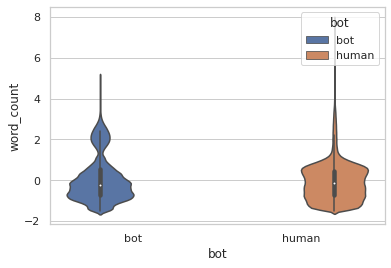

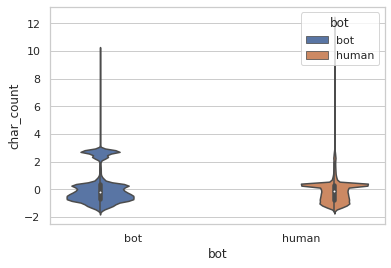

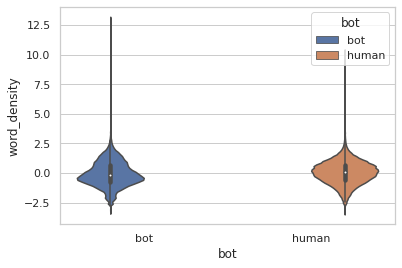

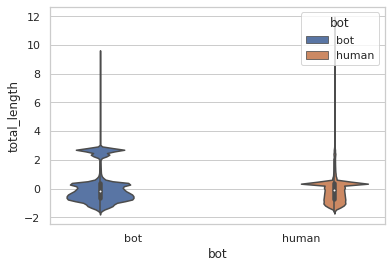

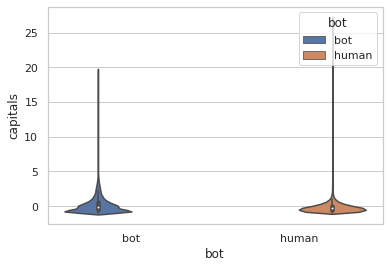

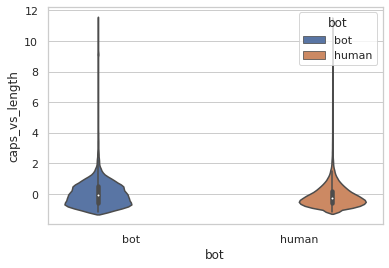

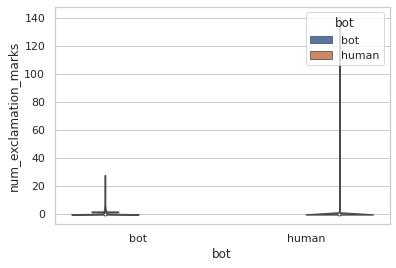

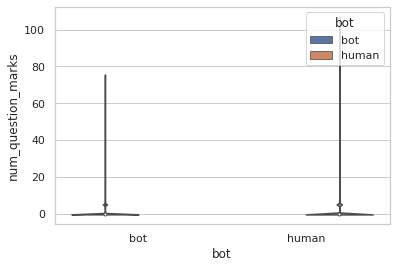

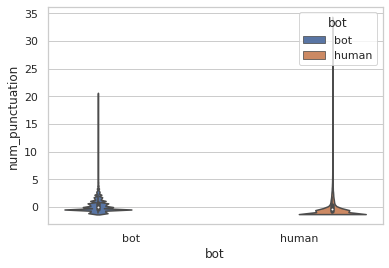

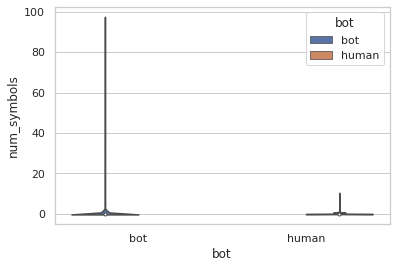

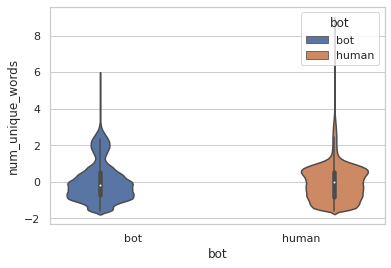

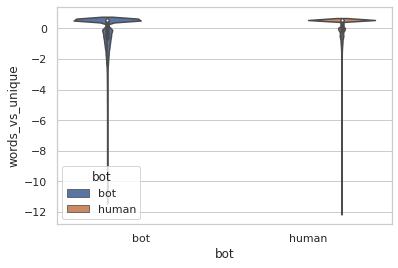

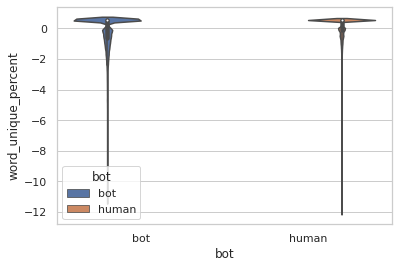

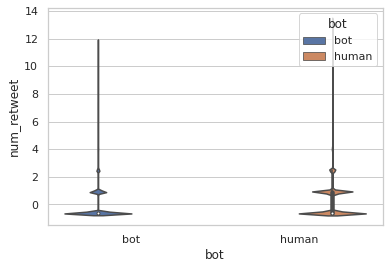

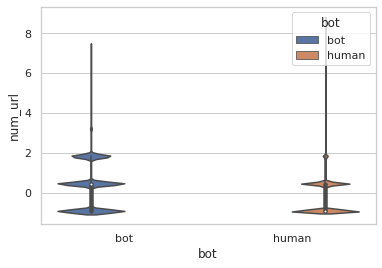

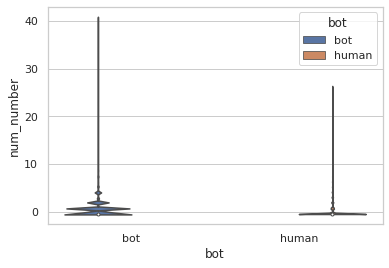

In [20]:
plot_violins_all(df)

(0.0, 300.0)

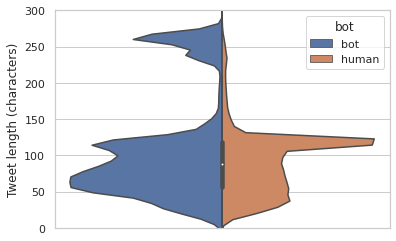

In [21]:
df_pre["both"] = ""
ax = sns.violinplot(x="both",
                    y="char_count",
                    split=True,
                    scale="count",
                    hue="bot",
                    data=df_pre)
ax.set_ylabel("Tweet length (characters)")
ax.set_xlabel("")
plt.ylim(0, 300)

(0.0, 20.0)

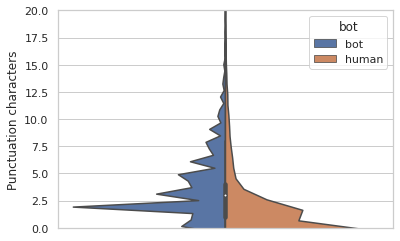

In [22]:
ax = sns.violinplot(x="both",
                    y="num_punctuation",
                    split=True,
                    scale="count",
                    hue="bot",
                    data=df_pre)
ax.set_ylabel("Punctuation characters")
ax.set_xlabel("")
plt.ylim(0, 20)

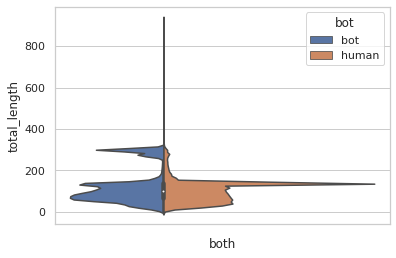

In [25]:
ax = sns.violinplot(x="both",
                    y="total_length",
                    split=True,
                    hue="bot",
                    data=df_pre)
#plt.ylim(0, 1)

In [24]:

df_train.to_pickle("./pan19_df_clean_train_full_features.pkl")
df_test.to_pickle("./pan19_df_clean_test_full_features.pkl")